### List of tables:

1. [Table 4: Treatment effects on quality](#quality)

In [1]:
%matplotlib inline

#### Imports libraries

In [2]:
import matplotlib.pyplot as plt #plotting
import numpy as np #matrix algebra
import os #file system handling
import sys
import pandas as pd #dataframe handling
import re # regular expression
import statsmodels.api as sm #regression analysis
import statsmodels.formula.api as smf # regressions analysis

from linearmodels.panel import RandomEffects #panel analysis 
from statsmodels.iolib.summary2 import summary_col #regression output table
from matplotlib.ticker import FuncFormatter #formating graphs 

#### Turn off pandas' future warnings

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Import  tools

In [4]:
sys.path.insert(0, '../')
from tools import MyPanelModelComparison

#### Set project directory

In [42]:
PROJECT_FOLDER = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
FINAL_DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data', 'final')
TABLES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'tables')
FIGURES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'figures', 'pandas')

#### Set display format

In [6]:
pd.options.display.float_format = '{:.3f}'.format

#### Set plotting style

In [7]:
plt.style.use('classic')

#### Set plotting properties 

In [8]:
bar_kwargs = dict(kind='bar', color='0.4', alpha=0.8, lw=0.5, width=0.7)
line_kwargs = dict(kind='line', lw=1, alpha=1, legend=True)
tick_kwargs = dict(size=5, which='both', right=False, top=False, direction='out', labelbottom=True)
font_kwargs = dict(fontsize=11, color='k')
grid_kwargs = dict(linewidth=1, axis="y", zorder=2, antialiased=True)
xlabel_kwargs = dict(fontsize=11, labelpad=3)
ylabel_kwargs = dict(fontsize=11, labelpad=3)
e_kwargs = dict(elinewidth=2, ecolor='0.15')
legend_kwargs = dict(frameon=False)

#### Retrieving dataframe

In [9]:
DATA = os.path.join(FINAL_DATA_FOLDER, 'benefit_data.feather')
df = pd.read_feather(DATA)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3094 entries, 0 to 3093
Columns: 441 entries, age to question80_timer
dtypes: float64(223), int64(25), object(193)
memory usage: 10.4+ MB


#### Sort dataframe by treatment 

In [10]:
df = df.sort_values('treatment')

#### Exclude subjects for which the timer did not work (10 min +/- 5%)

In [11]:
broken_timer = (df.duration_work < 600 * 0.95)|(df.duration_work > 600 * 1.05)
df = df[~broken_timer]

#### Seperate quality concern-treatments from the following main analysys

In [12]:
sel = (df.dataset != 6)
df = df[sel]

#### Reshape dataframe for panel analysis 

In [13]:
columns_to_keep = df.columns[[0, 10, 12, 18, 19, 27, 28, 30, 32, 33, 34, 35, 36, 37, 38]]
columns_to_melt = ['question{0}_editratio'.format(x) for x in range(1, df.counter.max() + 1)]

df_melted = pd.melt(
    df, 
    id_vars=columns_to_keep,
    value_vars = columns_to_melt,
    var_name='question_number',
    value_name='edit_ratio'
)

df_melted = df_melted.dropna(axis=0, how='any', subset=['edit_ratio'])
df_melted['question_number'] = df_melted['question_number'].str.extract(r'(\d+)').astype(int)
df_melted['edit_ratio'] = df_melted['edit_ratio'].astype(float)

df_panel = df_melted.set_index(['workerid', 'question_number'])
df_panel = df_panel.sort_index()
df_panel.head(20)  

age  education  female  latin  mobile_device  \
workerid question_number                                                   
0        1               43.000          2       1      2              0   
         2               43.000          2       1      2              0   
         3               43.000          2       1      2              0   
         4               43.000          2       1      2              0   
         5               43.000          2       1      2              0   
         6               43.000          2       1      2              0   
         7               43.000          2       1      2              0   
         8               43.000          2       1      2              0   
         9               43.000          2       1      2              0   
         10              43.000          2       1      2              0   
         11              43.000          2       1      2              0   
         12              43.000          2       1      2              0   
         13              43.000          2       1      2              0   
         14              43.000          2       1      2              0   
         15              43.000          2       1      2              0   
         16              43.000          2       1      2              0   
         17              43.000          2       1      2              0   
         18              43.000          2       1      2              0   
         19              43.000          2       1      2              0   
         20              43.000          2       1      2              0   

                         treatment_first treatment_second   treatment_third  \
workerid question_number                                                      
0        1                 No piece rate     Expectations  No Clarification   
         2                 No piece rate     Expectations  No Clarification   
         3                 No piece rate     Expectations  No Clarification   
         4                 No piece rate     Expectations  No Clarification   
         5                 No piece rate     Expectations  No Clarification   
         6                 No piece rate     Expectations  No Clarification   
         7                 No piece rate     Expectations  No Clarification   
         8                 No piece rate     Expectations  No Clarification   
         9                 No piece rate     Expectations  No Clarification   
         10                No piece rate     Expectations  No Clarification   
         11                No piece rate     Expectations  No Clarification   
         12                No piece rate     Expectations  No Clarification   
         13                No piece rate     Expectations  No Clarification   
         14                No piece rate     Expectations  No Clarification   
         15                No piece rate     Expectations  No Clarification   
         16                No piece rate     Expectations  No Clarification   
         17                No piece rate     Expectations  No Clarification   
         18                No piece rate     Expectations  No Clarification   
         19                No piece rate     Expectations  No Clarification   
         20                No piece rate     Expectations  No Clarification   

                          high_piece_rate  low_piece_rate  no_piece_rate  \
workerid question_number                                                   
0        1                              0               0              1   
         2                              0               0              1   
         3                              0               0              1   
         4                              0               0              1   
         5                              0               0              1   
         6                              0               0              1   
        

#### Table 4: Treatment effects on quality <a id='quality'></a> 

In [48]:
regs = dict()
regs['re1'] = 'edit_ratio ~ 1 + low_piece_rate + high_piece_rate'
regs['re2'] = 'edit_ratio ~ 1 + expectations + goal'
regs['re3'] = 'edit_ratio ~ 1 + (low_piece_rate + high_piece_rate) * (expectations + goal)'
regs['re4'] = regs['re3'] + ' + age + female + education + mobile_device + latin'

re_results = []
for k, v in regs.items():
    re_result = RandomEffects.from_formula(formula=v, data=df_panel).fit(cov_type='robust')
    re_results.append(re_result)
re_qual = MyPanelModelComparison(re_results)

path = os.path.join(TABLES_FOLDER, 're_quality.tex')
with open(path, "w") as latex:
   latex.write(re_qual.summary.as_latex())

display(re_qual)

,Model 0,Model 1,Model 2,Model 3
Dep. Variable,edit_ratio,edit_ratio,edit_ratio,edit_ratio
Estimator,RandomEffects,RandomEffects,RandomEffects,RandomEffects
No. Observations,62026,62026,62026,62026
Cov. Est.,Robust,Robust,Robust,Robust
R-squared,0.0019,0.0019,0.0020,0.0024
R-Squared (Within),0.0000,0.0000,0.0000,0.0000
R-Squared (Between),0.0008,0.0004,0.0031,0.0134
R-Squared (Overall),-0.0018,-0.0019,-0.0018,0.0005
F-statistic,58.979,58.519,15.444,11.586
P-value (F-stat),0.0000,0.0000,0.0000,0.0000


In [15]:
df_edit_ratio_first = df_panel\
    .groupby('treatment_first')\
    .apply(lambda x: x.mean(level=1))\
    .loc[:,'edit_ratio']\
    .unstack(level=0)\
    .sort_index(axis=1, ascending=False)


df_edit_ratio_second = df_panel\
    .groupby('treatment_second')\
    .apply(lambda x: x.mean(level=1))\
    .loc[:,'edit_ratio']\
    .unstack(level=0)\
    .sort_index(axis=1, ascending=False)

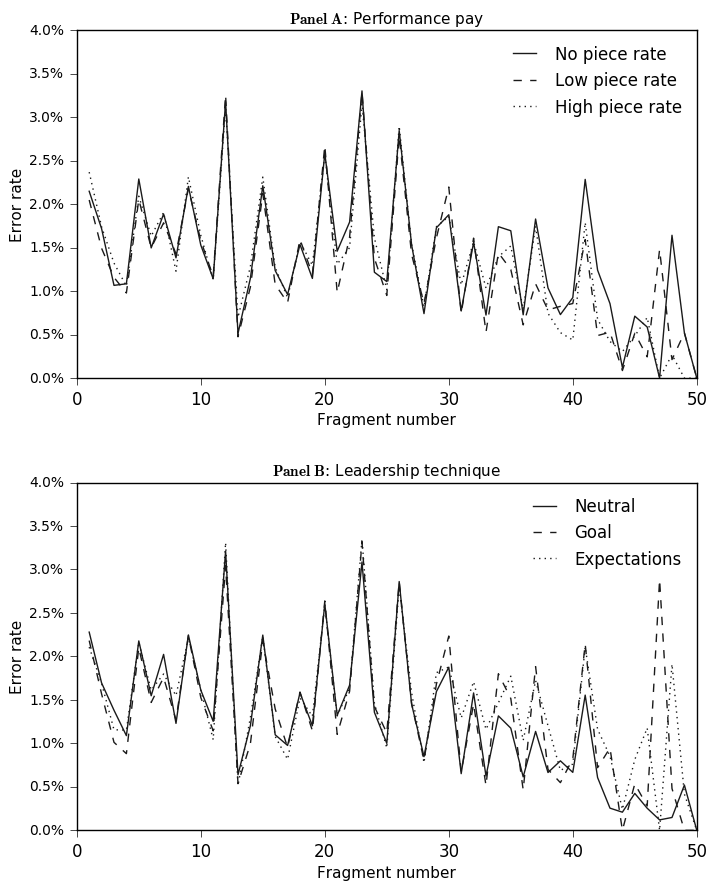

In [47]:
fig, axis = plt.subplots(nrows=2, figsize=(8, 10), dpi=100, facecolor='w')
fig.subplots_adjust(hspace=0.30)
axis[0].set_title('$\mathbf{Panel \ A}$: Performance pay', **font_kwargs)
axis[1].set_title('$\mathbf{Panel \ B}$: Leadership technique', **font_kwargs)
df_edit_ratio_first.plot(ax=axis[0], color='0.1', style=['-', '--',  ':'])
df_edit_ratio_second.plot(ax=axis[1], color='0.1', style=['-', '--', ':'])
for ax in axis:
    ax.tick_params(axis='x', **tick_kwargs)
    ax.tick_params(axis='y', labelsize='small', **tick_kwargs)
    ax.set_xlabel("Fragment number", **xlabel_kwargs)
    ax.set_ylabel("Error rate", **ylabel_kwargs)
    ax.set_ylim(0.0, .04) 
    ax.set_xlim(0.0, 50)
    ax.legend(frameon=False, fontsize='medium') 
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.savefig(os.path.join(FIGURES_FOLDER, 'error_rate.pdf'), bbox_inches='tight')

#### Calculate the time averaged error score and merge resuts with cross-sectional dataframe

In [17]:
avg_edit_ratio = df_panel['edit_ratio'].mean(level=0).to_frame(name='avg_edit_ratio')
df = df.merge(avg_edit_ratio, left_on='workerid', right_on='workerid', validate='one_to_one')

#### Treatment effects on quality using pooled OLS <a id='quality_ols'></a> 

In [46]:
regs = dict()
regs['re1'] = 'avg_edit_ratio ~ 1 + low_piece_rate + high_piece_rate'
regs['re2'] = 'avg_edit_ratio ~ 1 + expectations + goal'
regs['re3'] = 'avg_edit_ratio ~ 1 + (low_piece_rate + high_piece_rate) * (expectations + goal)'
regs['re4'] = regs['re3'] + ' + age + female + education + mobile_device + latin'
 
ols_results = []
for k, v in regs.items():
    ols = smf.ols(formula=v, data=df).fit()
    ols = ols.get_robustcov_results()
    ols_results.append(ols)

order = [
    'low_piece_rate', 
    'high_piece_rate', 
    'expectations', 
    'goal',
    'low_piece_rate:expectations', 
    'high_piece_rate:expectations', 
    'low_piece_rate:goal', 
    'high_piece_rate:goal',
    'age', 
    'female', 
    'education', 
    'mobile_device', 
    'latin',
    'Intercept', 
] 

auxiliary = {
    'N': lambda x: "{:d}".format(int(x.nobs)), 
    'R2': lambda x: "{:.3f}".format(x.rsquared)
}
ols_qual = summary_col(
    ols_results, 
    stars=True, 
    info_dict=auxiliary, 
    float_format='%.3f', 
    regressor_order=order
)
ols_qual = ols_qual\
    .tables[0]\
    .rename(mapper=lambda x: x.replace('_', ' ').replace(':', ' * ').capitalize(), axis=0)\
    .rename(mapper=lambda x: x.capitalize().split()[0].replace('_', ' '), axis=1)\

ols_qual.to_latex(
    os.path.join(TABLES_FOLDER, 'ols_quality.tex'), 
    bold_rows=True, 
    float_format="%.3f"
)
    
display(ols_qual)

,Avg edit ratio,Avg edit ratio,Avg edit ratio,Avg edit ratio
Low piece rate,-0.001,,-0.001,-0.001
,(0.001),,(0.001),(0.001)
High piece rate,0.001,,0.004,0.004
,(0.002),,(0.004),(0.004)
Expectations,,-0.000,0.002,0.003
,,(0.002),(0.003),(0.003)
Goal,,-0.001,-0.001,-0.001
,,(0.001),(0.001),(0.001)
Low piece rate * expectations,,,-0.002,-0.002
,,,(0.003),(0.003)
